In [1]:
#| default_exp core

In [2]:
import sys
print("Python version")
print (sys.version)

Python version
3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [3]:
#| export
import os
import io
import sys
import yaml
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub

from PIL import Image
from IPython.display import SVG, display
from diffusers import FluxPipeline
from transformers import BitsAndBytesConfig
from transformers.models.gemma3 import Gemma3ForConditionalGeneration, Gemma3Processor

svg_constraints = kagglehub.package_import('metric/svg-constraints')
dirpath_sup = kagglehub.dataset_download("yijiey/drawingwithllm-sup")
dirpath_flux = kagglehub.dataset_download("yijiey/flux-1-schnell")
dirpath_llm = kagglehub.model_download("google/gemma-3/transformers/gemma-3-12b-it/1")
filepath_prompt = os.path.join(dirpath_sup, "LLM_prompt.yaml")
filepath_primitive = os.path.join(dirpath_sup, "primitive.so")

sys.path.append(dirpath_sup)
from svg_draw import img2svg
from svg_optimizer import process_svg

2025-04-20 00:26:12.129458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745108772.368274      54 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745108772.439297      54 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# #| export

# # Compile the C code to a shared library from dirpath_sup
# !apt update
# !apt install build-essential
# !gcc --version
# # Compile the C code to a shared library using the correct path
# !gcc -shared -fPIC -O3 {os.path.join(dirpath_sup, "primitive.c")} -o primitive.so -lm

# # Copy the compiled .so file to the expected location in /kaggle/input
# !cp primitive.so /kaggle/working/primitive.so

In [5]:
#| export
cuda_devices = [f"cuda:{i}" for i in range(torch.cuda.device_count())]
print(cuda_devices)

device1 = "cuda:0"
device2 = "cuda:1"

['cuda:0', 'cuda:1']


In [6]:
#| export
import time

class Model:
    def __init__(self):
        # Start timing model initialization
        self.init_start_time = time.time()

        # === Load LLM ===
        # quant_config = BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     bnb_4bit_quant_type="nf4",
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_compute_dtype=torch.bfloat16,
        # ) # Only 4bit quantization works for GEMMA-3-12b-it
        # quant_config = BitsAndBytesConfig(load_in_8bit=True) # 8-bit quantization
    
        # self.processor = Gemma3Processor.from_pretrained(dirpath_llm)
        # self.LLM = Gemma3ForConditionalGeneration.from_pretrained(
        #     dirpath_llm, 
        #     quantization_config=quant_config,
        #     torch_dtype=torch.bfloat16,
        #     device_map=device2
        # ).eval()

        # Load the template from YAML file
        # with open(filepath_prompt, 'r') as file:
        #     self.template = yaml.safe_load(file)["template"]

        # === Load T2I ===
        self.pipe = FluxPipeline.from_pretrained(
            dirpath_flux, 
            torch_dtype=torch.bfloat16,
            device_map = "balanced"
        )
        
        # self.pipe.enable_sequential_cpu_offload()  # Offloads modules to CPU when not in use
        # self.pipe.enable_attention_slicing()  # Additional memory optimization
        
        _ = self.predict("a purple forest at dusk")
        
        # Record initialization completion time
        self.init_time = time.time() - self.init_start_time
        print(f"Model initialization completed in {self.init_time:.2f} seconds")

    def T2I(self, text):
        image = self.pipe(
            text, # Maximum number of tokens allowed (default: 77)
            num_inference_steps=2, 
            guidance_scale=3.5,  # No classifier-free guidance
            height=512,
            width=512,
        ).images[0]
        return image

    def display(self, image):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Generated Image')
        plt.show()

    def request(self, messages):
        inputs = self.processor.apply_chat_template(
            messages, 
            add_generation_prompt=True, 
            tokenize=True,
            return_dict=True, 
            return_tensors="pt",
        ).to(device2, dtype=torch.bfloat16)
        
        input_len = inputs["input_ids"].shape[-1]
        
        with torch.inference_mode():
            generation = self.LLM.generate(**inputs, max_new_tokens=256, do_sample=False)
            generation = generation[0][input_len:]
            
        decoded = self.processor.decode(generation, skip_special_tokens=True)
        return decoded

    def generate_LLM_prompt(self, desc):
        LLM_prompt = self.template.format(description=desc)
        return LLM_prompt

    def generate_T2I_prompt(self, prompt):
        messages = [
            {
                "role": "system",
                "content": [{"type": "text", "text": "You are a helpful assistant."}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt}
                ]
            }
        ]
        return self.request(messages)

    
    def generate_T2I_prompt_with_template(self, desc):
        template = "a minimalist, flat cartoon-style SVG illustration of {description}, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering"
        return template.format(description=desc)
    
    def predict(self, desc):
        # Start timing this prediction
        pred_start_time = time.time()
        
        # === Generate LLM Prompt ===
        # LLM_prompt = self.generate_LLM_prompt(desc)

        # === Generate T2I Prompt ===
        # T2I_prompt = self.generate_T2I_prompt(LLM_prompt)
        T2I_prompt = self.generate_T2I_prompt_with_template(desc)
        print("T2I Prompt:", T2I_prompt)

        # === Generate Image Based on T2I Prompt ===
        image = self.T2I(T2I_prompt) # Not necessary 256 x 256

        # === Convert Image to SVG ===
        svg_string = img2svg(
            image, 
            steps=150,           # Customize number of triangles
            candidates=500,      # Customize number of candidates
            mutations=100,        # Customize number of mutations
            verbose=False,
            lib_path=filepath_primitive,
        )
        
        svg_string = process_svg(svg_string)
        
        self.display(image)
        display(SVG(svg_string))
        # svg_filename = f"{desc}.svg"
        # with open(os.path.join(r"/kaggle/working/", svg_filename), "w", encoding="utf-8") as f:
            # f.write(svg_string)
            
        # Calculate timing information
        pred_time = time.time() - pred_start_time
        total_run_time = time.time() - self.init_start_time
        
        print(f"SVG conversion complete, size: {len(svg_string)} bytes")
        print(f"Time statistics:")
        print(f"  - This prediction took: {pred_time:.2f} seconds")
        print(f"  - Total time since model initialization: {total_run_time:.2f} seconds")
        
        return svg_string

In [7]:
# import kaggle_evaluation
# kaggle_evaluation.test(Model)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a purple forest at dusk, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

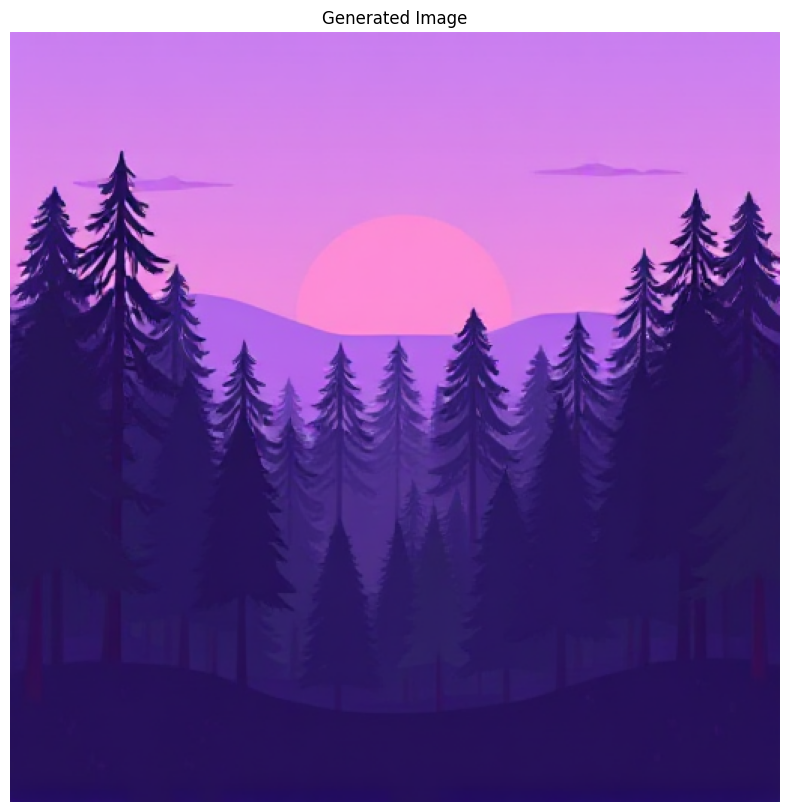

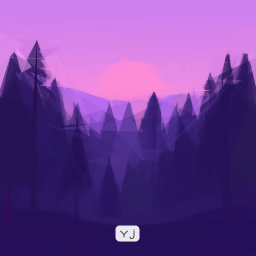

SVG conversion complete, size: 9868 bytes
Time statistics:
  - This prediction took: 207.70 seconds
  - Total time since model initialization: 283.03 seconds
Model initialization completed in 283.03 seconds
Description: a purple forest at dusk
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a purple forest at dusk, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

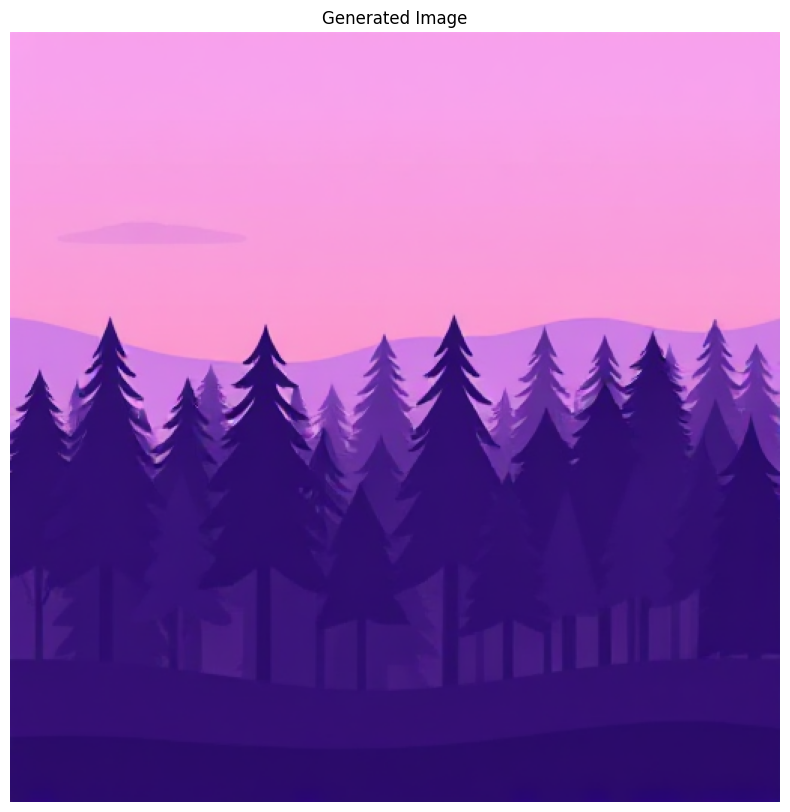

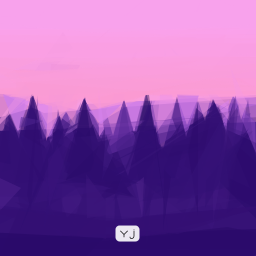

SVG conversion complete, size: 9941 bytes
Time statistics:
  - This prediction took: 49.51 seconds
  - Total time since model initialization: 332.56 seconds
Description: gray wool coat with a faux fur collar
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of gray wool coat with a faux fur collar, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

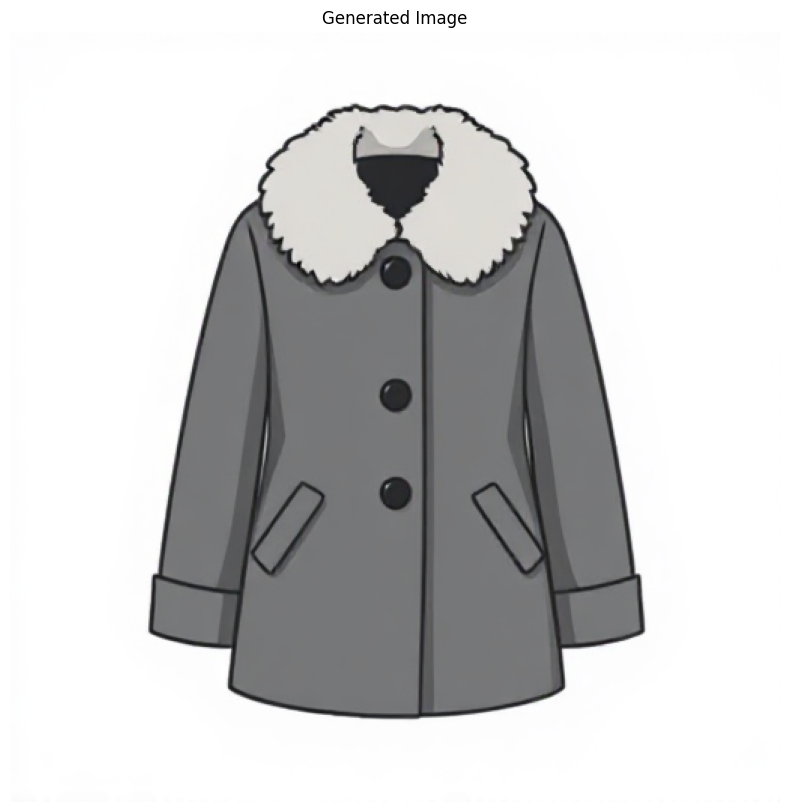

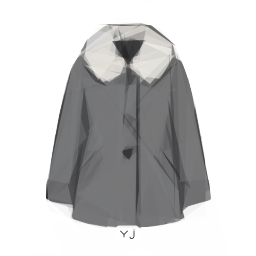

SVG conversion complete, size: 9657 bytes
Time statistics:
  - This prediction took: 57.03 seconds
  - Total time since model initialization: 389.59 seconds
Description: a lighthouse overlooking the ocean
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a lighthouse overlooking the ocean, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

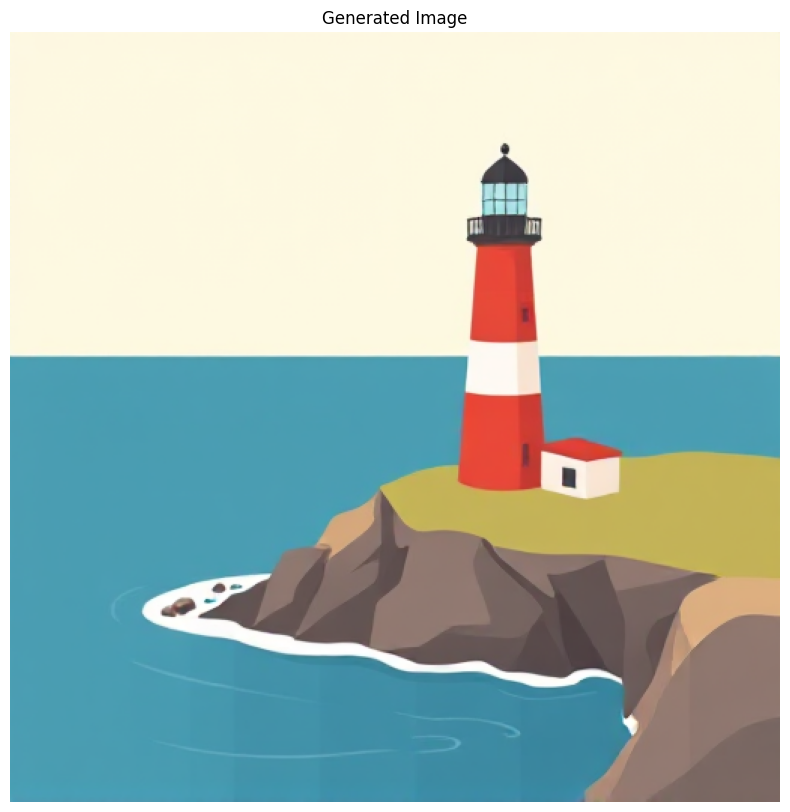

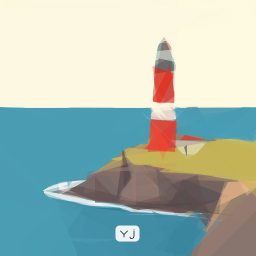

SVG conversion complete, size: 9930 bytes
Time statistics:
  - This prediction took: 53.53 seconds
  - Total time since model initialization: 443.12 seconds
Description: burgundy corduroy pants with patch pockets and silver buttons
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of burgundy corduroy pants with patch pockets and silver buttons, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

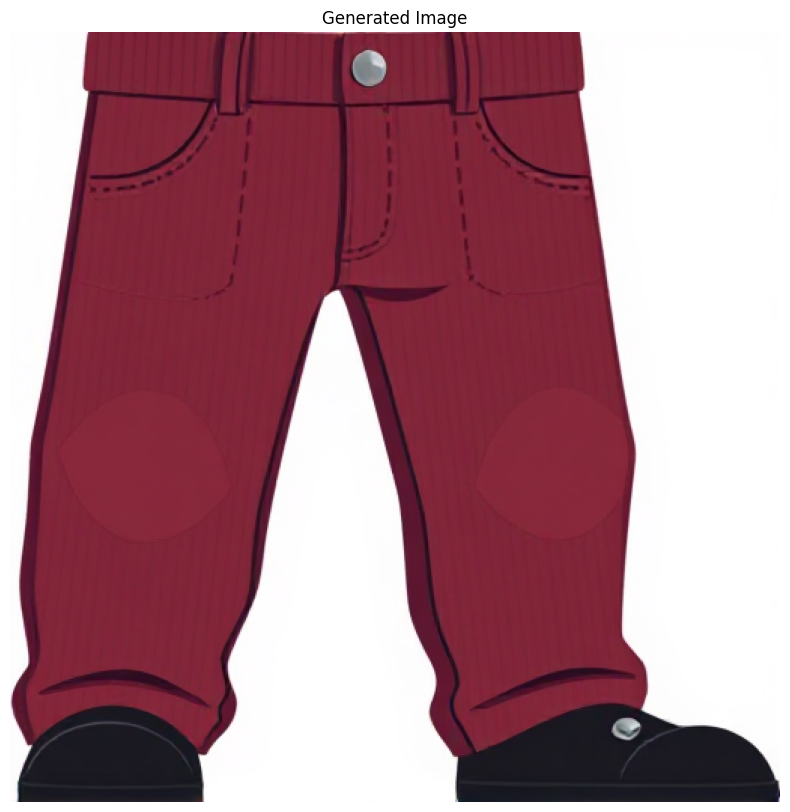

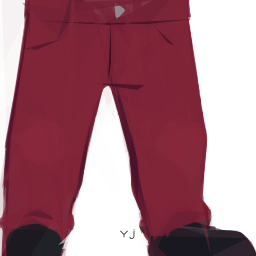

SVG conversion complete, size: 9757 bytes
Time statistics:
  - This prediction took: 54.59 seconds
  - Total time since model initialization: 497.71 seconds
Description: orange corduroy overalls
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of orange corduroy overalls, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

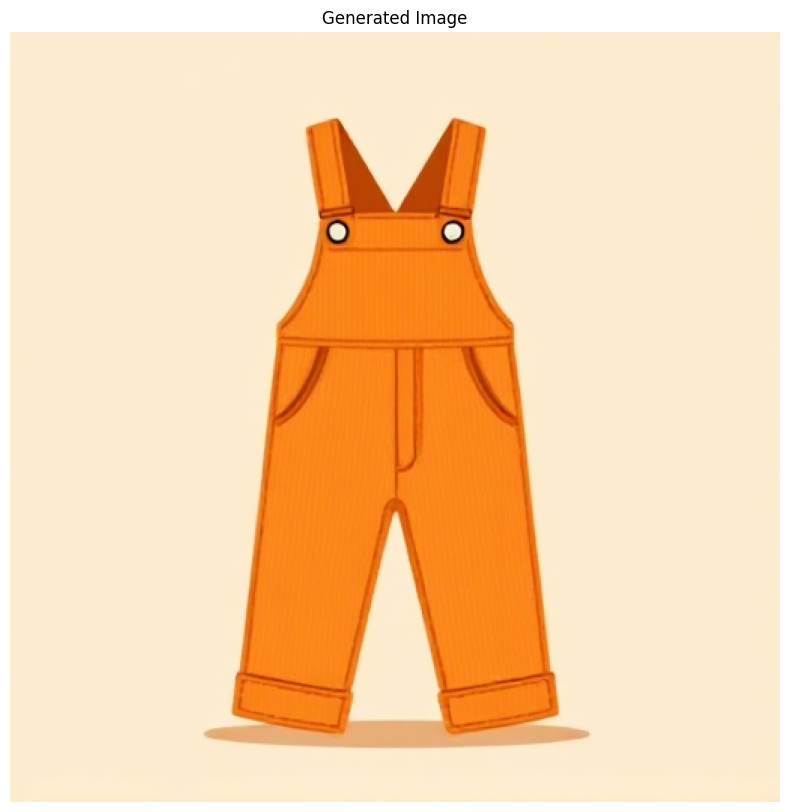

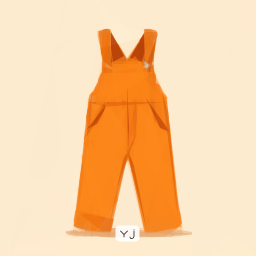

SVG conversion complete, size: 9955 bytes
Time statistics:
  - This prediction took: 58.86 seconds
  - Total time since model initialization: 556.58 seconds
Description: a purple silk scarf with tassel trim
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a purple silk scarf with tassel trim, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

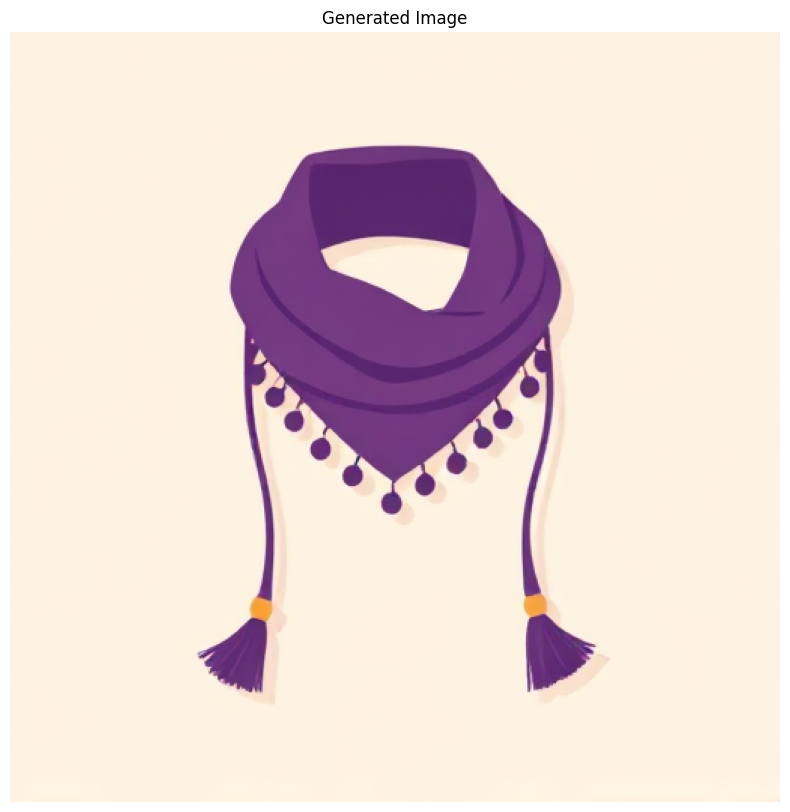

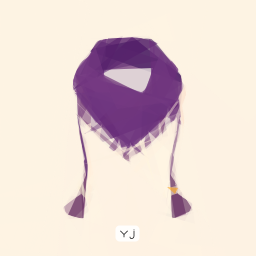

SVG conversion complete, size: 9919 bytes
Time statistics:
  - This prediction took: 58.71 seconds
  - Total time since model initialization: 615.29 seconds
Description: a green lagoon under a cloudy sky
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a green lagoon under a cloudy sky, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

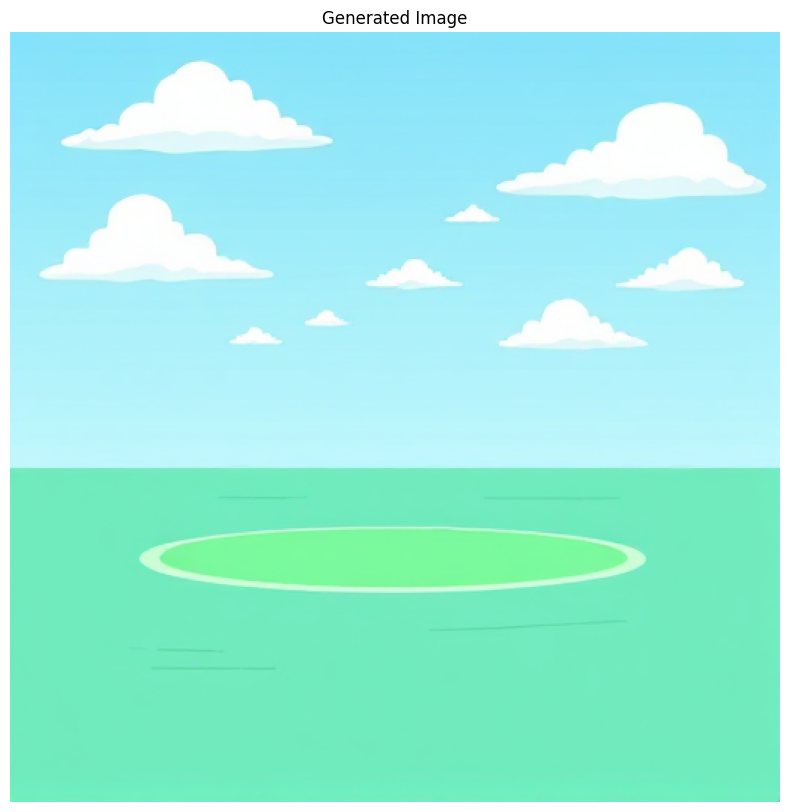

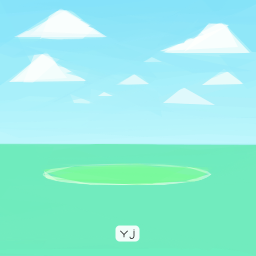

SVG conversion complete, size: 9934 bytes
Time statistics:
  - This prediction took: 53.76 seconds
  - Total time since model initialization: 669.04 seconds
Description: crimson rectangles forming a chaotic grid
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of crimson rectangles forming a chaotic grid, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

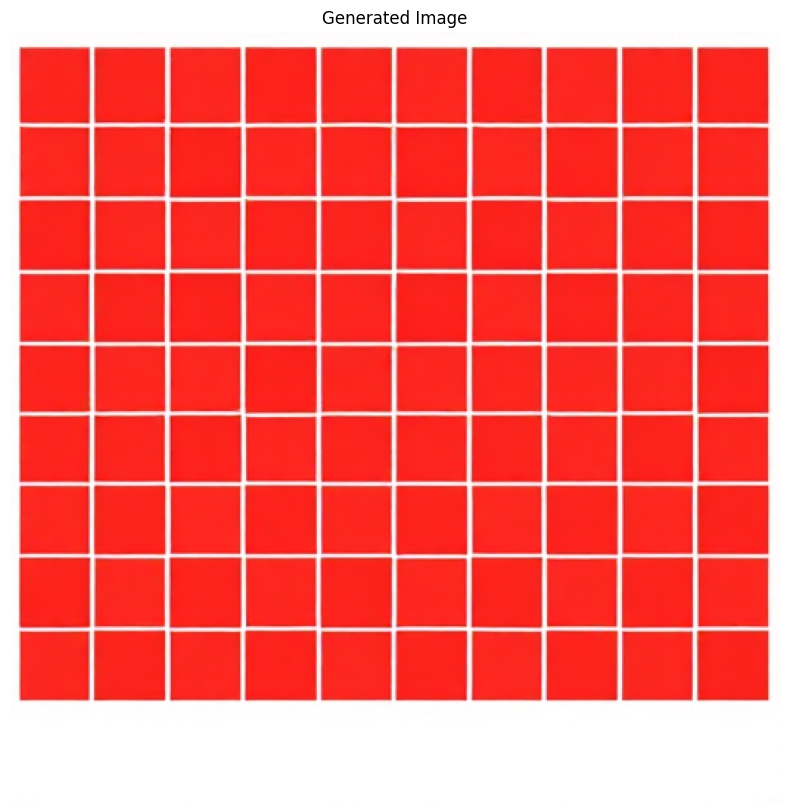

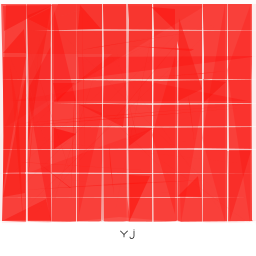

SVG conversion complete, size: 9738 bytes
Time statistics:
  - This prediction took: 50.28 seconds
  - Total time since model initialization: 719.32 seconds
Description: purple pyramids spiraling around a bronze cone
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of purple pyramids spiraling around a bronze cone, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

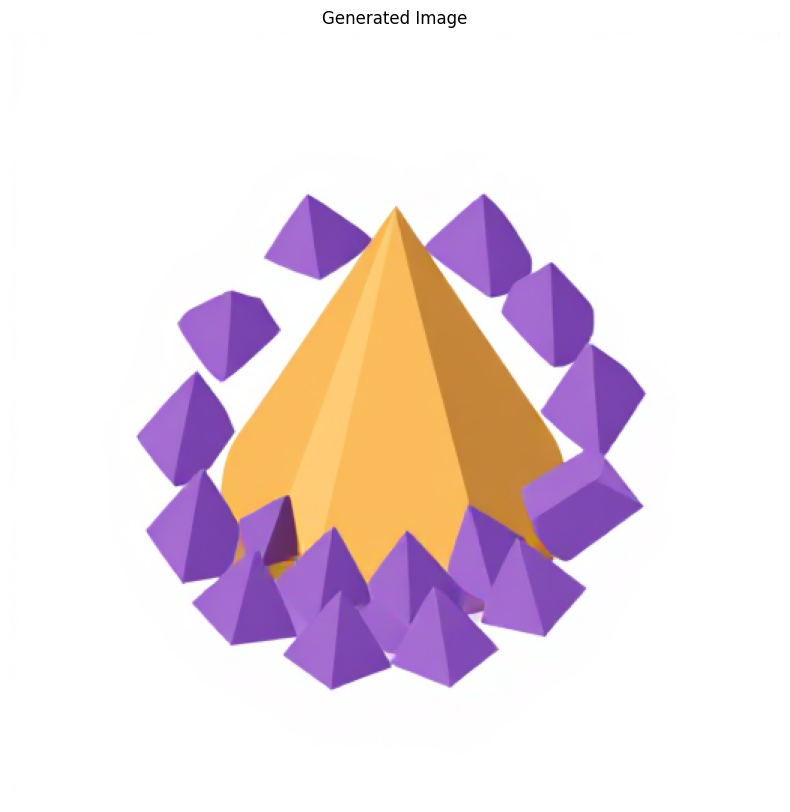

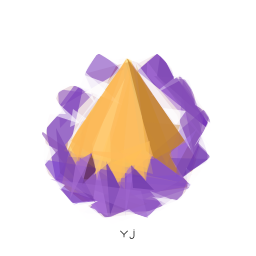

SVG conversion complete, size: 9688 bytes
Time statistics:
  - This prediction took: 58.45 seconds
  - Total time since model initialization: 777.77 seconds
Description: magenta trapezoids layered on a transluscent silver sheet
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of magenta trapezoids layered on a transluscent silver sheet, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

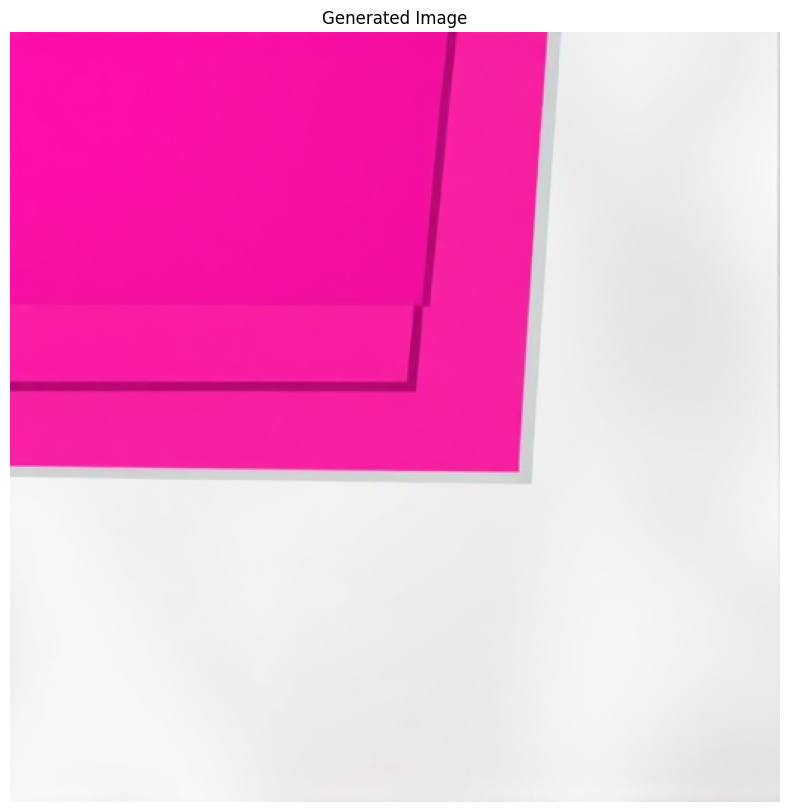

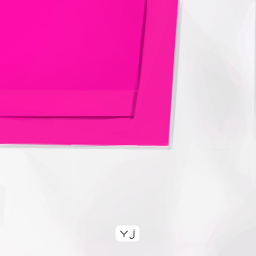

SVG conversion complete, size: 9904 bytes
Time statistics:
  - This prediction took: 49.15 seconds
  - Total time since model initialization: 826.92 seconds
Description: a snowy plain
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a snowy plain, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

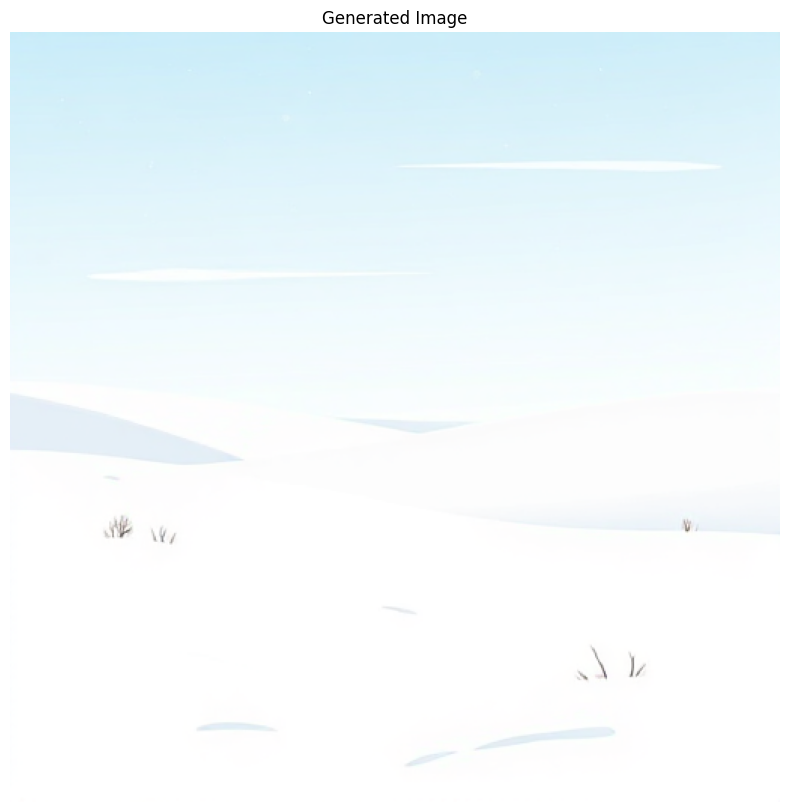

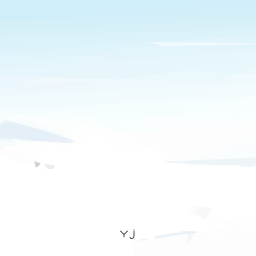

SVG conversion complete, size: 9705 bytes
Time statistics:
  - This prediction took: 67.13 seconds
  - Total time since model initialization: 894.05 seconds
Description: black and white checkered pants
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of black and white checkered pants, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

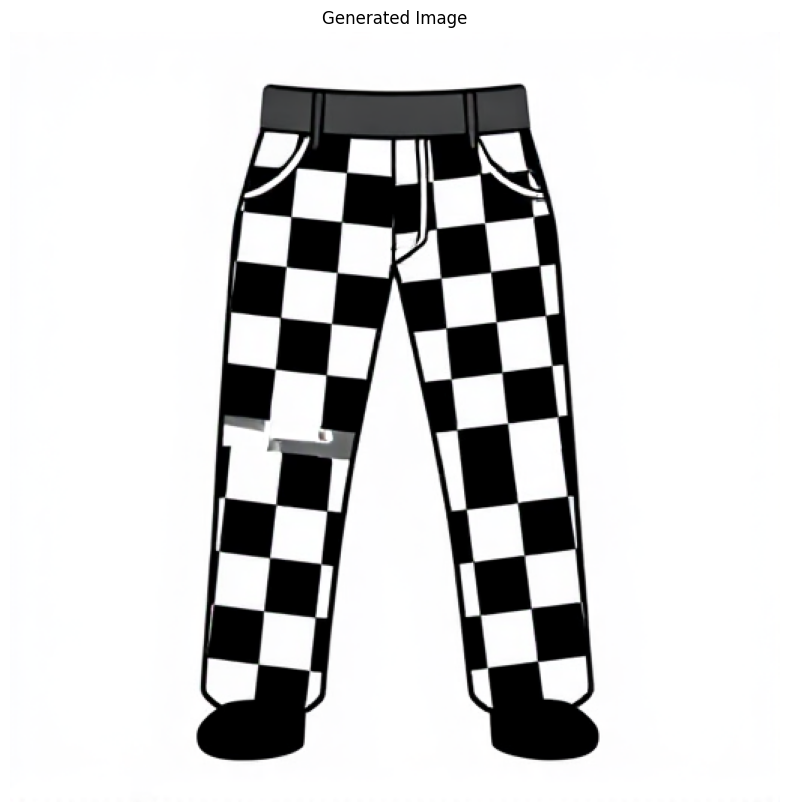

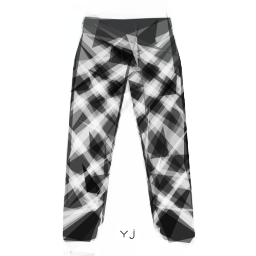

SVG conversion complete, size: 9583 bytes
Time statistics:
  - This prediction took: 53.41 seconds
  - Total time since model initialization: 947.46 seconds
Description: a starlit night over snow-covered peaks
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a starlit night over snow-covered peaks, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

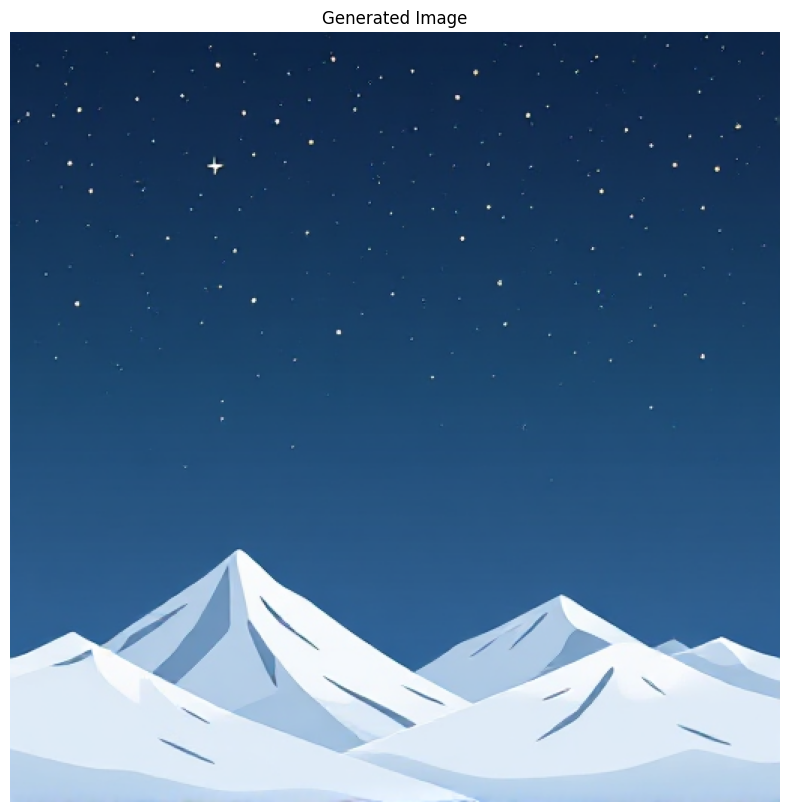

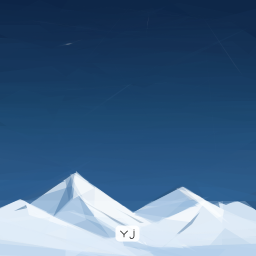

SVG conversion complete, size: 9888 bytes
Time statistics:
  - This prediction took: 47.20 seconds
  - Total time since model initialization: 994.66 seconds
Description: khaki triangles and azure crescents
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of khaki triangles and azure crescents, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

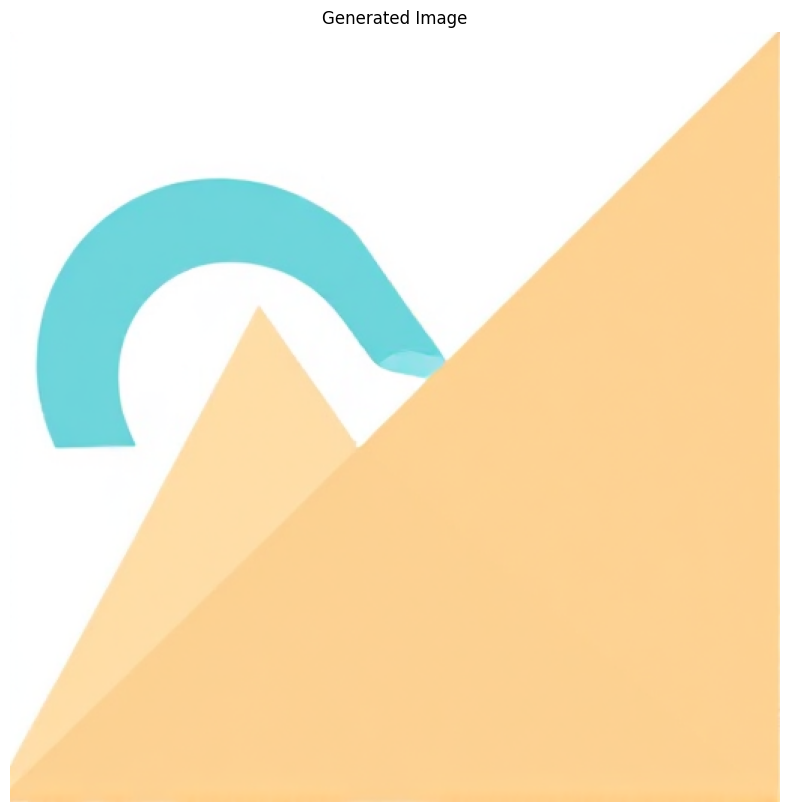

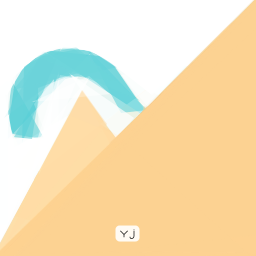

SVG conversion complete, size: 9837 bytes
Time statistics:
  - This prediction took: 69.56 seconds
  - Total time since model initialization: 1064.22 seconds
Description: a maroon dodecahedron interwoven with teal threads
T2I Prompt: a minimalist, flat cartoon-style SVG illustration of a maroon dodecahedron interwoven with teal threads, with simple shapes and limited colors, maintaining clear spatial relationships and explicit positioning and layering


  0%|          | 0/2 [00:00<?, ?it/s]

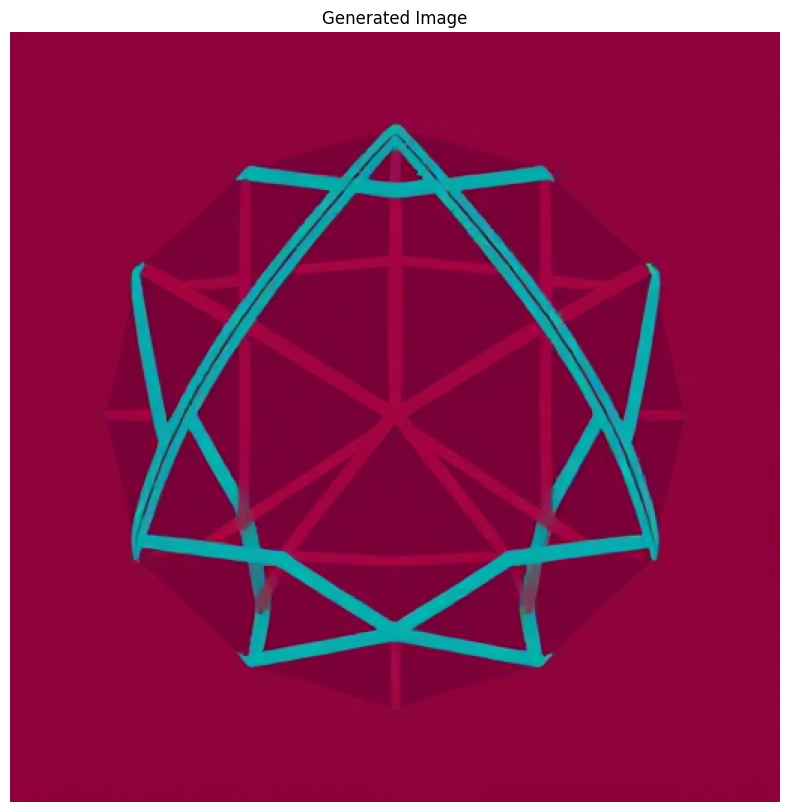

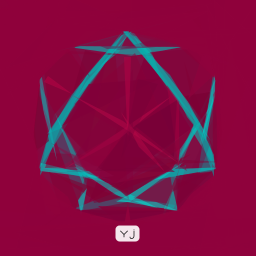

SVG conversion complete, size: 9944 bytes
Time statistics:
  - This prediction took: 49.49 seconds
  - Total time since model initialization: 1113.71 seconds


In [8]:
# Initialize Model
model = Model()

# Read the CSV file
df_train = pd.read_csv(r"/kaggle/input/drawing-with-llms/train.csv")
id_to_description = dict(zip(df_train['id'], df_train['description']))

ids = list(id_to_description.keys())

for i in range(len(ids)):
    desc = id_to_description[ids[i]]
    print("Description:", desc)
    model.predict(desc)